In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from collections import defaultdict
from socket import gethostbyname, gaierror
import socket
from urllib3.connection import HTTPConnection
import time
import minet
from minet.twitter import TwitterAPIScraper
from ast import literal_eval


# Tâche 1 : scraper la liste de tous les domaines que MBFC considère être ‘Low Credibility’ et dont le ‘Traffic’ est ‘Medium’ ou ‘High’

In [15]:
def get_domains(traffic,credibility) :
    #on pourrait également sélectionner/trouver ces 9 liens via la pages d'accueil et le bouton bias categories 
    #mais les liens direct me paraissaient plus sûr en terme de perenité (changement de label du bouton etc..)
    menulist=['https://mediabiasfactcheck.com/left/','https://mediabiasfactcheck.com/leftcenter/',
              'https://mediabiasfactcheck.com/center/','https://mediabiasfactcheck.com/right-center/',
              'https://mediabiasfactcheck.com/right/','https://mediabiasfactcheck.com/conspiracy/',
              'https://mediabiasfactcheck.com/fake-news/','https://mediabiasfactcheck.com/pro-science/',
              'https://mediabiasfactcheck.com/satire/']
    pageslinks=[]
    #we go to each bias categories page and get the list of pages links on it
    for elt in menulist : 
        r =requests.get(elt)
        if r.status_code ==200 :
            soup = BeautifulSoup(r.text, 'html.parser')
            for td in soup.find_all('td'):
                a=td.select('a')
                if a :
                    pageslinks.append(a[0]['href'])
    pageslink=list(set(pageslinks))
    credibilityscore_list=[]
    trafficscore_list=[]
    pageslist=[]
    domainslist=[]
    i=1
    #we iterate over these pages
    for page in pageslink :
        print(str(i)+"/"+str(len(pageslink)))
        print(page)
        r =requests.get(page)
        #make sure the request go through
        if r.status_code ==200 :
            domain=None
            soup = BeautifulSoup(r.text, 'html.parser')
            pagetext=soup.get_text().lower() 
            #Get the domain url
            #structure can change a bit hence the parent or parent.parent
            pattern=re.compile("Source:(\s)*")
            elt=soup.find_all(string=pattern)
            if elt :
                elt_parent=elt[0].parent
                a=elt_parent.select('a')
                if a :
                    domain=a[0]["href"]
                else :
                    a=elt_parent.parent.select('a')
                    if a :
                        domain=a[0]["href"]
            #if we're able to get the domain we retrieve the mbfc credibility core and traffic/popularity scale
            #some pages don't have the "source: url"
            if domain :
                pageslist.append(page)
                domainslist.append(domain)
                cred_match=re.search("(?<=mbfc credibility rating:)(\s)*[a-z]+(\s)*credibility",pagetext)
                traffic_match=re.search("(?<=traffic/popularity:)(\s)*[a-z]+(\s)*traffic",pagetext)
                #some pages don't have mbfc score and/or traffic score
                if cred_match :
                    cred_match=re.sub("(\s)*credibility","",cred_match.group()).strip()
                    credibilityscore_list.append(cred_match)
                else:
                    print("no credibility score found")
                    credibilityscore_list.append("")
                if traffic_match:
                    traffic_match=re.sub("(\s)*traffic","",traffic_match.group()).strip()
                    trafficscore_list.append(traffic_match)
                else:
                    print("no traffic score found")
                    trafficscore_list.append("")         
            else :
                print("domain/source not found")
        i+=1
    """on pourrait également crééer la dataframe directement avec uniquement le trafic/et credibility 
    qu'on recherche ou inversement renvoyer la dataframe complète et la filtrer par la suite """
    df=pd.DataFrame.from_dict({"mbfc_url":pageslist,"domain":domainslist,"credibility_score":credibilityscore_list,"traffic_popularity":trafficscore_list})
    print("number of websites overall : ",len(df))
    #keep only the desired parameters here medium or high for traffic and low for credibility
    res=df[df.traffic_popularity.isin(traffic) & df.credibility_score.isin(credibility)]
    print("number of websites with chosen criterias : ",len(res))
    return df

In [12]:
domains_df=get_domains(["medium","high"],["low"])

1/4672
https://mediabiasfactcheck.com/ktft-twin-falls-news-bias/
2/4672
https://mediabiasfactcheck.com/kswo-lawton-news-bias/
3/4672
https://mediabiasfactcheck.com/patriotic-post-bias/
4/4672
https://mediabiasfactcheck.com/virginia-mercury/
5/4672
https://mediabiasfactcheck.com/illicit-info/
6/4672
https://mediabiasfactcheck.com/health-nut-news/
no credibility score found
no traffic score found
7/4672
https://mediabiasfactcheck.com/tri-city-sun-bias/
8/4672
https://mediabiasfactcheck.com/wnbw-gainesville-news-bias/
9/4672
https://mediabiasfactcheck.com/global-research/
10/4672
https://mediabiasfactcheck.com/globe-gazette-iowa/
11/4672
https://mediabiasfactcheck.com/fitsnews/
12/4672
https://mediabiasfactcheck.com/canadian-anti-hate-network-bias/
13/4672
https://mediabiasfactcheck.com/ft-bragg-advocate-news/
14/4672
https://mediabiasfactcheck.com/eu-observer/
15/4672
https://mediabiasfactcheck.com/wall-street-journal/
16/4672
https://mediabiasfactcheck.com/stamford-advocate/
17/4672
htt

118/4672
https://mediabiasfactcheck.com/lew-rockwell/
119/4672
https://mediabiasfactcheck.com/wyzz-bloomington-news-bias/
120/4672
https://mediabiasfactcheck.com/votefraud-news/
121/4672
https://mediabiasfactcheck.com/the-politics-online/
122/4672
https://mediabiasfactcheck.com/daily-reckoning/
123/4672
https://mediabiasfactcheck.com/committee-constructive-tomorrow-cfact-org/
124/4672
https://mediabiasfactcheck.com/american-action-news/
125/4672
https://mediabiasfactcheck.com/ksee-fresno-news-bias/
126/4672
https://mediabiasfactcheck.com/pasadena-star-news-bias/
127/4672
https://mediabiasfactcheck.com/the-conservative-papers/
128/4672
https://mediabiasfactcheck.com/waow-wausau-news-bias/
129/4672
https://mediabiasfactcheck.com/frontiers-in-aerospace-engineering-bias/
130/4672
https://mediabiasfactcheck.com/secure-america-now/
131/4672
https://mediabiasfactcheck.com/wgtu-traverse-city-news/
132/4672
https://mediabiasfactcheck.com/gay-city-news-bias/
133/4672
https://mediabiasfactcheck.c

no credibility score found
no traffic score found
240/4672
https://mediabiasfactcheck.com/bounding-into-comics/
241/4672
https://mediabiasfactcheck.com/we-are-change/
242/4672
https://mediabiasfactcheck.com/the-daily-wire/
243/4672
https://mediabiasfactcheck.com/korean-central-news-agency/
244/4672
https://mediabiasfactcheck.com/rocketnews/
245/4672
https://mediabiasfactcheck.com/times-headline/
246/4672
https://mediabiasfactcheck.com/real-clear-defense/
no credibility score found
no traffic score found
247/4672
https://mediabiasfactcheck.com/wjab-npr-huntsville-bias/
248/4672
https://mediabiasfactcheck.com/corona-transition/
249/4672
https://mediabiasfactcheck.com/the-nevada-independent/
no credibility score found
no traffic score found
250/4672
https://mediabiasfactcheck.com/space-com/
no credibility score found
no traffic score found
251/4672
https://mediabiasfactcheck.com/dallas-morning-news/
252/4672
https://mediabiasfactcheck.com/wlwt-cincinnati-news-bias/
253/4672
https://mediab

354/4672
https://mediabiasfactcheck.com/wzdx-huntsville-news-bias/
355/4672
https://mediabiasfactcheck.com/vidmax-2/
356/4672
https://mediabiasfactcheck.com/the-olympian/
357/4672
https://mediabiasfactcheck.com/star-political/
no credibility score found
no traffic score found
358/4672
https://mediabiasfactcheck.com/americas-news-source/
359/4672
https://mediabiasfactcheck.com/harvard-gazette/
360/4672
https://mediabiasfactcheck.com/bno-news/
361/4672
https://mediabiasfactcheck.com/kbtx-news-3/
362/4672
https://mediabiasfactcheck.com/atchison-daily-globe-bias/
363/4672
https://mediabiasfactcheck.com/black-press-usa-bias/
364/4672
https://mediabiasfactcheck.com/independent-sentinel/
365/4672
https://mediabiasfactcheck.com/military-times/
366/4672
https://mediabiasfactcheck.com/kvew-kennewick-news/
367/4672
https://mediabiasfactcheck.com/teddy-stick/
no credibility score found
no traffic score found
368/4672
https://mediabiasfactcheck.com/fstv-freespeech-org/
369/4672
https://mediabiasfac

481/4672
https://mediabiasfactcheck.com/greenmedinfo/
482/4672
https://mediabiasfactcheck.com/american-center-law-justice-aclj/
483/4672
https://mediabiasfactcheck.com/the-standard-kenya/
484/4672
https://mediabiasfactcheck.com/alliance-defending-freedom/
485/4672
https://mediabiasfactcheck.com/bicester-advertiser-bias/
486/4672
https://mediabiasfactcheck.com/gaia/
487/4672
https://mediabiasfactcheck.com/houma-thibodaux-news-bias/
488/4672
https://mediabiasfactcheck.com/wpmi-mobile-news/
489/4672
https://mediabiasfactcheck.com/the-citizen-south-africa/
490/4672
https://mediabiasfactcheck.com/wmtv-news/
491/4672
https://mediabiasfactcheck.com/rock-island-today/
492/4672
https://mediabiasfactcheck.com/ada-derana-bias/
493/4672
https://mediabiasfactcheck.com/inside-philanthropy/
no credibility score found
no traffic score found
494/4672
https://mediabiasfactcheck.com/plymouth-reporter-bias/
495/4672
https://mediabiasfactcheck.com/india-today/
496/4672
https://mediabiasfactcheck.com/west-s

601/4672
https://mediabiasfactcheck.com/peninsula-daily-news/
no credibility score found
no traffic score found
602/4672
https://mediabiasfactcheck.com/kfvs-cape-girardeau-news-bias/
603/4672
https://mediabiasfactcheck.com/sacramento-standard/
604/4672
https://mediabiasfactcheck.com/sciencing/
605/4672
https://mediabiasfactcheck.com/keye-austin-news-bias/
606/4672
https://mediabiasfactcheck.com/summit-daily-news-bias/
607/4672
https://mediabiasfactcheck.com/central-iowa-times-bias/
608/4672
https://mediabiasfactcheck.com/cop-block/
609/4672
https://mediabiasfactcheck.com/bnc-black-news-channel-bias/
610/4672
https://mediabiasfactcheck.com/gainesville-sun/
611/4672
https://mediabiasfactcheck.com/joebiden-news/
612/4672
https://mediabiasfactcheck.com/east-arapahoe-news/
613/4672
https://mediabiasfactcheck.com/kcby-north-bend-news-bias/
614/4672
https://mediabiasfactcheck.com/republic-report/
no credibility score found
no traffic score found
615/4672
https://mediabiasfactcheck.com/kolo-8-

719/4672
https://mediabiasfactcheck.com/occupy-yourself/
no credibility score found
no traffic score found
720/4672
https://mediabiasfactcheck.com/mooresville-tribune-bias/
721/4672
https://mediabiasfactcheck.com/opposing-views/
722/4672
https://mediabiasfactcheck.com/scitechdaily/
723/4672
https://mediabiasfactcheck.com/institute-for-womens-policy-research-iwpr/
724/4672
https://mediabiasfactcheck.com/natural-resources-defense-council/
725/4672
https://mediabiasfactcheck.com/ethics-religious-liberty-commission-erlc/
726/4672
https://mediabiasfactcheck.com/the-liberty-revolution-bias/
727/4672
https://mediabiasfactcheck.com/kbjr-duluth-news-bias/
728/4672
https://mediabiasfactcheck.com/tva-nouvelles-bias/
729/4672
https://mediabiasfactcheck.com/grunion-gazette-bias/
730/4672
https://mediabiasfactcheck.com/waco-tribune-herald-bias-credibility-rating/
731/4672
https://mediabiasfactcheck.com/east-valley-tribune-bias/
732/4672
https://mediabiasfactcheck.com/kveo-rio-grande-valley-news-bias

837/4672
https://mediabiasfactcheck.com/understanding-the-threat/
838/4672
https://mediabiasfactcheck.com/boing-boing/
839/4672
https://mediabiasfactcheck.com/new-humanist/
840/4672
https://mediabiasfactcheck.com/dc-dirty-laundry/
841/4672
https://mediabiasfactcheck.com/bossip/
842/4672
https://mediabiasfactcheck.com/global-news/
843/4672
https://mediabiasfactcheck.com/smartnews/
844/4672
https://mediabiasfactcheck.com/scoopwhoop/
no credibility score found
no traffic score found
845/4672
https://mediabiasfactcheck.com/ipsos-polling/
846/4672
https://mediabiasfactcheck.com/cbs-seattle-cw-11-bias/
847/4672
https://mediabiasfactcheck.com/vulture/
848/4672
https://mediabiasfactcheck.com/futurism/
849/4672
https://mediabiasfactcheck.com/klax-alexandria-news-bias/
850/4672
https://mediabiasfactcheck.com/rare-news/
no credibility score found
no traffic score found
851/4672
https://mediabiasfactcheck.com/ktal-shreveport-news-bias/
852/4672
https://mediabiasfactcheck.com/newser/
853/4672
https

961/4672
https://mediabiasfactcheck.com/national-file/
962/4672
https://mediabiasfactcheck.com/discover-magazine/
963/4672
https://mediabiasfactcheck.com/jewish-breaking-news/
no credibility score found
no traffic score found
964/4672
https://mediabiasfactcheck.com/nhk-nippon-hoso-kyokai/
965/4672
https://mediabiasfactcheck.com/the-straits-times/
966/4672
https://mediabiasfactcheck.com/the-monitor-texas/
no credibility score found
no traffic score found
967/4672
https://mediabiasfactcheck.com/just-security/
968/4672
https://mediabiasfactcheck.com/prevention-magazine/
969/4672
https://mediabiasfactcheck.com/american-journal-of-archaeology/
970/4672
https://mediabiasfactcheck.com/maga-daily-report/
no credibility score found
no traffic score found
971/4672
https://mediabiasfactcheck.com/kauz-wichita-falls-news-bias/
972/4672
https://mediabiasfactcheck.com/the-auburn-citizen/
no credibility score found
no traffic score found
973/4672
https://mediabiasfactcheck.com/votesmart/
974/4672
http

1080/4672
https://mediabiasfactcheck.com/world-population-review/
1081/4672
https://mediabiasfactcheck.com/rand-corporation/
1082/4672
https://mediabiasfactcheck.com/clayton-record-bias/
1083/4672
https://mediabiasfactcheck.com/times-news-pennsylvania/
1084/4672
https://mediabiasfactcheck.com/toofab/
1085/4672
https://mediabiasfactcheck.com/west-contra-costa-news/
1086/4672
https://mediabiasfactcheck.com/the-american-mind/
1087/4672
https://mediabiasfactcheck.com/chambana-sun/
1088/4672
https://mediabiasfactcheck.com/pan-american-health-organization-paho/
1089/4672
https://mediabiasfactcheck.com/boston-com/
1090/4672
https://mediabiasfactcheck.com/international-rescue-committee-irc/
no credibility score found
no traffic score found
1091/4672
https://mediabiasfactcheck.com/wcsc-charleston-news/
1092/4672
https://mediabiasfactcheck.com/grundy-reporter-bias/
1093/4672
https://mediabiasfactcheck.com/globe-magazine/
1094/4672
https://mediabiasfactcheck.com/the-daily-northwestern/
no credibi

1203/4672
https://mediabiasfactcheck.com/variety-magazine/
1204/4672
https://mediabiasfactcheck.com/the-sun/
1205/4672
https://mediabiasfactcheck.com/24jours-com/
1206/4672
https://mediabiasfactcheck.com/the-sociable/
1207/4672
https://mediabiasfactcheck.com/chatham-house-bias/
1208/4672
https://mediabiasfactcheck.com/the-muskokan-bias/
1209/4672
https://mediabiasfactcheck.com/the-bulwark/
1210/4672
https://mediabiasfactcheck.com/americans-for-truth-aftah/
1211/4672
https://mediabiasfactcheck.com/bbc-science-focus-bias/
1212/4672
https://mediabiasfactcheck.com/albany-times-union/
1213/4672
https://mediabiasfactcheck.com/dailysnark/
no credibility score found
1214/4672
https://mediabiasfactcheck.com/aftonbladet/
1215/4672
https://mediabiasfactcheck.com/the-postillion/
no credibility score found
1216/4672
https://mediabiasfactcheck.com/world-resources-institute-wri/
1217/4672
https://mediabiasfactcheck.com/the-flip-side/
1218/4672
https://mediabiasfactcheck.com/mercatornet/
1219/4672
htt

1329/4672
https://mediabiasfactcheck.com/cns-news/
1330/4672
https://mediabiasfactcheck.com/walb-albany-ga-bias/
1331/4672
https://mediabiasfactcheck.com/wabg-deltanews-bias/
1332/4672
https://mediabiasfactcheck.com/san-marcos-daily-record/
no credibility score found
no traffic score found
1333/4672
https://mediabiasfactcheck.com/the-laugh-club/
1334/4672
https://mediabiasfactcheck.com/the-daily-chronicle/
1335/4672
https://mediabiasfactcheck.com/national-enquirer/
1336/4672
https://mediabiasfactcheck.com/south-gwinnett-news/
1337/4672
https://mediabiasfactcheck.com/the-republic-indiana/
1338/4672
https://mediabiasfactcheck.com/world-press-review/
1339/4672
https://mediabiasfactcheck.com/def-con-news-bias/
1340/4672
https://mediabiasfactcheck.com/the-voice-uk/
1341/4672
https://mediabiasfactcheck.com/the-waking-times/
no credibility score found
no traffic score found
1342/4672
https://mediabiasfactcheck.com/arab-news/
1343/4672
https://mediabiasfactcheck.com/verywell/
1344/4672
https:/

1447/4672
https://mediabiasfactcheck.com/asia-sentinel/
1448/4672
https://mediabiasfactcheck.com/the-irrawaddy/
1449/4672
https://mediabiasfactcheck.com/seeker-daily/
no credibility score found
no traffic score found
1450/4672
https://mediabiasfactcheck.com/deleware-ohio-news-bias/
no credibility score found
1451/4672
https://mediabiasfactcheck.com/the-spectator-uk/
1452/4672
https://mediabiasfactcheck.com/kemptville-advance-bias/
1453/4672
https://mediabiasfactcheck.com/law-com/
domain/source not found
1454/4672
https://mediabiasfactcheck.com/barrhead-news-bias/
1455/4672
https://mediabiasfactcheck.com/west-valley-view-bias/
1456/4672
https://mediabiasfactcheck.com/coconino-news/
1457/4672
https://mediabiasfactcheck.com/everyday-health-science-credible/
1458/4672
https://mediabiasfactcheck.com/news-global-bias/
1459/4672
https://mediabiasfactcheck.com/the-argonaut-bias/
1460/4672
https://mediabiasfactcheck.com/gilbert-sun-news-bias/
1461/4672
https://mediabiasfactcheck.com/who-what-wh

1565/4672
https://mediabiasfactcheck.com/healthy-and-natural-world/
1566/4672
https://mediabiasfactcheck.com/liberty-videos/
no credibility score found
no traffic score found
1567/4672
https://mediabiasfactcheck.com/essex-echo-bias/
1568/4672
https://mediabiasfactcheck.com/atlas-obscura/
1569/4672
https://mediabiasfactcheck.com/southern-indiana-today-bias/
1570/4672
https://mediabiasfactcheck.com/daily-signal/
1571/4672
https://mediabiasfactcheck.com/amomama/
1572/4672
https://mediabiasfactcheck.com/moscow-24/
1573/4672
https://mediabiasfactcheck.com/vaccine-impact/
1574/4672
https://mediabiasfactcheck.com/american-college-of-pediatricians/
1575/4672
https://mediabiasfactcheck.com/denver-post/
1576/4672
https://mediabiasfactcheck.com/organic-facts/
no credibility score found
no traffic score found
1577/4672
https://mediabiasfactcheck.com/the-spectator-usa/
1578/4672
https://mediabiasfactcheck.com/valuetainment-bias/
1579/4672
https://mediabiasfactcheck.com/atl-standard/
1580/4672
https

1686/4672
https://mediabiasfactcheck.com/mendocino-beacon-bias/
1687/4672
https://mediabiasfactcheck.com/ktvi-st-louis/
1688/4672
https://mediabiasfactcheck.com/citynews-halifax-bias/
1689/4672
https://mediabiasfactcheck.com/ars-technica/
1690/4672
https://mediabiasfactcheck.com/womens-rights-news/
1691/4672
https://mediabiasfactcheck.com/el-pais/
1692/4672
https://mediabiasfactcheck.com/mountaineer-echo-bias/
1693/4672
https://mediabiasfactcheck.com/infobae/
1694/4672
https://mediabiasfactcheck.com/wfie-evansville-news-bias/
1695/4672
https://mediabiasfactcheck.com/new-york-post/
1696/4672
https://mediabiasfactcheck.com/the-nation-pakistan/
1697/4672
https://mediabiasfactcheck.com/political-state/
no credibility score found
no traffic score found
1698/4672
https://mediabiasfactcheck.com/kwch-wichita-news-bias/
1699/4672
https://mediabiasfactcheck.com/chicago-sun-times/
1700/4672
https://mediabiasfactcheck.com/maine-beacon/
1701/4672
https://mediabiasfactcheck.com/ipolitics/
no credibi

1805/4672
https://mediabiasfactcheck.com/sw-bluegrass-news-bias/
1806/4672
https://mediabiasfactcheck.com/new-haven-register/
1807/4672
https://mediabiasfactcheck.com/better-government-association/
1808/4672
https://mediabiasfactcheck.com/united-states-citizenship-and-immigration-services-uscis/
1809/4672
https://mediabiasfactcheck.com/irin-news/
no credibility score found
no traffic score found
1810/4672
https://mediabiasfactcheck.com/newsammo/
no credibility score found
no traffic score found
1811/4672
https://mediabiasfactcheck.com/advocates-for-self-government/
1812/4672
https://mediabiasfactcheck.com/egyptian-streets/
1813/4672
https://mediabiasfactcheck.com/public-citizen/
no credibility score found
no traffic score found
1814/4672
https://mediabiasfactcheck.com/wptz-plattsburgh-news-bias/
1815/4672
https://mediabiasfactcheck.com/the-daily-tarheel/
1816/4672
https://mediabiasfactcheck.com/frank-speech-mike-lindell/
1817/4672
https://mediabiasfactcheck.com/manatee-review/
1818/467

1919/4672
https://mediabiasfactcheck.com/winter-watch/
1920/4672
https://mediabiasfactcheck.com/stimson-center/
no credibility score found
no traffic score found
1921/4672
https://mediabiasfactcheck.com/100-percent-fed-up/
1922/4672
https://mediabiasfactcheck.com/discover-the-networks/
1923/4672
https://mediabiasfactcheck.com/yaleglobal-online-bias-credibility-rating/
1924/4672
https://mediabiasfactcheck.com/capital-gazette/
1925/4672
https://mediabiasfactcheck.com/kpix-cbs-san-francisco/
1926/4672
https://mediabiasfactcheck.com/snowmass-sun-bias/
1927/4672
https://mediabiasfactcheck.com/wate-knoxville-news-bias/
1928/4672
https://mediabiasfactcheck.com/spectrum-news-ny1/
1929/4672
https://mediabiasfactcheck.com/luverne-journal-bias/
1930/4672
https://mediabiasfactcheck.com/antelope-valley-today/
1931/4672
https://mediabiasfactcheck.com/the-unz-report/
no credibility score found
no traffic score found
1932/4672
https://mediabiasfactcheck.com/cook-political-report/
1933/4672
https://med

2034/4672
https://mediabiasfactcheck.com/kktv-11-news/
2035/4672
https://mediabiasfactcheck.com/daily-news-bin/
no credibility score found
no traffic score found
2036/4672
https://mediabiasfactcheck.com/comox-valley-record-bias/
2037/4672
https://mediabiasfactcheck.com/source-newspaper-la-source/
2038/4672
https://mediabiasfactcheck.com/american-physical-society-aps/
2039/4672
https://mediabiasfactcheck.com/global-risk-insights-gri/
2040/4672
https://mediabiasfactcheck.com/energy-citizens/
2041/4672
https://mediabiasfactcheck.com/sentinel-ksmo/
2042/4672
https://mediabiasfactcheck.com/east-sfv-news/
2043/4672
https://mediabiasfactcheck.com/us-department-energy-office-science/
2044/4672
https://mediabiasfactcheck.com/maplight/
no credibility score found
no traffic score found
2045/4672
https://mediabiasfactcheck.com/wkow-madison-news-bias/
2046/4672
https://mediabiasfactcheck.com/business-standard-india/
2047/4672
https://mediabiasfactcheck.com/dayton-daily-news/
2048/4672
https://media

2153/4672
https://mediabiasfactcheck.com/american-psychological-association-apa/
no credibility score found
2154/4672
https://mediabiasfactcheck.com/the-intercept/
2155/4672
https://mediabiasfactcheck.com/newsday/
no credibility score found
no traffic score found
2156/4672
https://mediabiasfactcheck.com/askingangels-com/
2157/4672
https://mediabiasfactcheck.com/daily-grail/
2158/4672
https://mediabiasfactcheck.com/national-bureau-of-economic-research-nber/
2159/4672
https://mediabiasfactcheck.com/free-thought-project/
2160/4672
https://mediabiasfactcheck.com/pinal-today/
2161/4672
https://mediabiasfactcheck.com/gadsden-times-bias/
2162/4672
https://mediabiasfactcheck.com/dpa-german-press-agency/
2163/4672
https://mediabiasfactcheck.com/idaho-statesman/
no credibility score found
no traffic score found
2164/4672
https://mediabiasfactcheck.com/issues-in-science-and-technology/
2165/4672
https://mediabiasfactcheck.com/christian-news-alerts/
2166/4672
https://mediabiasfactcheck.com/skeptic

domain/source not found
2270/4672
https://mediabiasfactcheck.com/patriot-journal/
2271/4672
https://mediabiasfactcheck.com/new-scientist/
2272/4672
https://mediabiasfactcheck.com/the-mary-sue/
no credibility score found
no traffic score found
2273/4672
https://mediabiasfactcheck.com/macon-reporter-bias/
2274/4672
https://mediabiasfactcheck.com/conservative-beaver/
2275/4672
https://mediabiasfactcheck.com/leftcult/
2276/4672
https://mediabiasfactcheck.com/kiem-redwood-news-bias/
2277/4672
https://mediabiasfactcheck.com/foreign-policy/
2278/4672
https://mediabiasfactcheck.com/wkyt-news/
2279/4672
https://mediabiasfactcheck.com/pink-news/
no credibility score found
no traffic score found
2280/4672
https://mediabiasfactcheck.com/the-logic-of-science-bias/
2281/4672
https://mediabiasfactcheck.com/atlanta-journal-constitution/
2282/4672
https://mediabiasfactcheck.com/newscentermaine-com/
2283/4672
https://mediabiasfactcheck.com/usa-spending/
2284/4672
https://mediabiasfactcheck.com/la-porte-

2390/4672
https://mediabiasfactcheck.com/engadget/
2391/4672
https://mediabiasfactcheck.com/chico-times/
2392/4672
https://mediabiasfactcheck.com/rock-hill-herald/
2393/4672
https://mediabiasfactcheck.com/international-climate-science-coalition/
no credibility score found
no traffic score found
2394/4672
https://mediabiasfactcheck.com/jstore/
no credibility score found
no traffic score found
2395/4672
https://mediabiasfactcheck.com/higher-perspective/
2396/4672
https://mediabiasfactcheck.com/the-michigan-independent-bias/
2397/4672
https://mediabiasfactcheck.com/leicester-mercury/
2398/4672
https://mediabiasfactcheck.com/nw-kansas-news-bias/
2399/4672
https://mediabiasfactcheck.com/kurdistan-24/
2400/4672
https://mediabiasfactcheck.com/eclectic-observer-bias/
2401/4672
https://mediabiasfactcheck.com/se-denver-news/
2402/4672
https://mediabiasfactcheck.com/rockford-register-star-bias/
2403/4672
https://mediabiasfactcheck.com/weibo-bias/
2404/4672
https://mediabiasfactcheck.com/abc-news-

2507/4672
https://mediabiasfactcheck.com/newsmax/
2508/4672
https://mediabiasfactcheck.com/gnews/
2509/4672
https://mediabiasfactcheck.com/san-francisco-chronicle/
2510/4672
https://mediabiasfactcheck.com/greensboro-news-and-record/
no credibility score found
no traffic score found
2511/4672
https://mediabiasfactcheck.com/the-jerusalem-report/
2512/4672
https://mediabiasfactcheck.com/friends-of-science/
2513/4672
https://mediabiasfactcheck.com/the-red-elephants/
2514/4672
https://mediabiasfactcheck.com/meidastouch/
2515/4672
https://mediabiasfactcheck.com/the-asbury-park-press/
no credibility score found
no traffic score found
2516/4672
https://mediabiasfactcheck.com/c19melatonin-com-bias/
2517/4672
https://mediabiasfactcheck.com/bestlife/
2518/4672
https://mediabiasfactcheck.com/sayfie-review/
2519/4672
https://mediabiasfactcheck.com/wikinews/
2520/4672
https://mediabiasfactcheck.com/times-colonist/
no credibility score found
no traffic score found
2521/4672
https://mediabiasfactcheck

2625/4672
https://mediabiasfactcheck.com/hindustan-times/
2626/4672
https://mediabiasfactcheck.com/black-main-street/
2627/4672
https://mediabiasfactcheck.com/crisis-magazine/
2628/4672
https://mediabiasfactcheck.com/guido-fawkes/
no credibility score found
no traffic score found
2629/4672
https://mediabiasfactcheck.com/western-journalism/
2630/4672
https://mediabiasfactcheck.com/survivalblog-com/
no credibility score found
no traffic score found
2631/4672
https://mediabiasfactcheck.com/code-pink/
2632/4672
https://mediabiasfactcheck.com/9-news-australia/
2633/4672
https://mediabiasfactcheck.com/american-academy-of-pediatrics/
2634/4672
https://mediabiasfactcheck.com/daily-sound-and-fury/
2635/4672
https://mediabiasfactcheck.com/sfgate/
2636/4672
https://mediabiasfactcheck.com/watn-memphis-news-bias/
2637/4672
https://mediabiasfactcheck.com/wten-albany-news-bias/
2638/4672
https://mediabiasfactcheck.com/kutv-salt-lake-city/
no credibility score found
no traffic score found
2639/4672
ht

2739/4672
https://mediabiasfactcheck.com/al-jazeera/
2740/4672
https://mediabiasfactcheck.com/star-telegram/
no credibility score found
no traffic score found
2741/4672
https://mediabiasfactcheck.com/c19aspirin-com-bias/
2742/4672
https://mediabiasfactcheck.com/de-standaard-bias/
2743/4672
https://mediabiasfactcheck.com/kark-little-rock-news-bias/
2744/4672
https://mediabiasfactcheck.com/fark-com-bias/
no credibility score found
2745/4672
https://mediabiasfactcheck.com/the-express-times-lehigh-valley/
no credibility score found
no traffic score found
2746/4672
https://mediabiasfactcheck.com/krcg-jefferson-city-bias/
2747/4672
https://mediabiasfactcheck.com/claremont-institute/
2748/4672
https://mediabiasfactcheck.com/tuscaloosa-leader/
2749/4672
https://mediabiasfactcheck.com/elko-daily-free-press/
2750/4672
https://mediabiasfactcheck.com/prophecy-news-watch/
no credibility score found
no traffic score found
2751/4672
https://mediabiasfactcheck.com/4chan-bias/
domain/source not found
2

2853/4672
https://mediabiasfactcheck.com/health-ranger-report/
2854/4672
https://mediabiasfactcheck.com/geoengineering-news/
2855/4672
https://mediabiasfactcheck.com/agenzia-nazionale-stampa-associata-ansa/
2856/4672
https://mediabiasfactcheck.com/park-rapids-enterprise-bias/
2857/4672
https://mediabiasfactcheck.com/the-center-on-budget-and-policy-priorities/
2858/4672
https://mediabiasfactcheck.com/vladtv-bias/
2859/4672
https://mediabiasfactcheck.com/american-immigration-council/
2860/4672
https://mediabiasfactcheck.com/la-nacion-argentina-bias/
2861/4672
https://mediabiasfactcheck.com/ozy-media/
2862/4672
https://mediabiasfactcheck.com/barry-and-district-news-bias/
2863/4672
https://mediabiasfactcheck.com/the-globe-and-mail/
2864/4672
https://mediabiasfactcheck.com/catholic-tribune-florida-bias/
2865/4672
https://mediabiasfactcheck.com/east-alameda-news/
2866/4672
https://mediabiasfactcheck.com/the-chaser/
no credibility score found
2867/4672
https://mediabiasfactcheck.com/entrepren

2975/4672
https://mediabiasfactcheck.com/daily-commercial-bias/
2976/4672
https://mediabiasfactcheck.com/nbc-5-dallas-fort-worth-kxas-bias/
2977/4672
https://mediabiasfactcheck.com/nc-minnesota-news-bias/
2978/4672
https://mediabiasfactcheck.com/climate-action-tracker/
2979/4672
https://mediabiasfactcheck.com/competitive-enterprise-institute/
2980/4672
https://mediabiasfactcheck.com/ktvx-salt-lake-city-news/
2981/4672
https://mediabiasfactcheck.com/tpl-news/
2982/4672
https://mediabiasfactcheck.com/outkick/
2983/4672
https://mediabiasfactcheck.com/electroverse/
2984/4672
https://mediabiasfactcheck.com/times-san-diego/
2985/4672
https://mediabiasfactcheck.com/kezi-eugene-news-bias/
2986/4672
https://mediabiasfactcheck.com/activist-mommy/
2987/4672
https://mediabiasfactcheck.com/breitbart/
2988/4672
https://mediabiasfactcheck.com/san-francisco-examiner/
no credibility score found
no traffic score found
2989/4672
https://mediabiasfactcheck.com/beach-broadcast-news-bias/
2990/4672
https://

3093/4672
https://mediabiasfactcheck.com/the-vaccine-reaction/
domain/source not found
3094/4672
https://mediabiasfactcheck.com/real-clear-investigations/
3095/4672
https://mediabiasfactcheck.com/imprimis-hillsdale-college/
no credibility score found
no traffic score found
3096/4672
https://mediabiasfactcheck.com/st-john-news-bias/
3097/4672
https://mediabiasfactcheck.com/verdugos-news/
3098/4672
https://mediabiasfactcheck.com/scienceblogs/
no credibility score found
no traffic score found
3099/4672
https://mediabiasfactcheck.com/pluralist/
no credibility score found
no traffic score found
3100/4672
https://mediabiasfactcheck.com/above-the-law/
3101/4672
https://mediabiasfactcheck.com/jezebel/
no credibility score found
no traffic score found
3102/4672
https://mediabiasfactcheck.com/big-news-network/
3103/4672
https://mediabiasfactcheck.com/norfolk-reporter-bias/
3104/4672
https://mediabiasfactcheck.com/kstp-tv/
3105/4672
https://mediabiasfactcheck.com/aspen-institute/
3106/4672
https:

3205/4672
https://mediabiasfactcheck.com/wthi-terre-haute-news-bias/
3206/4672
https://mediabiasfactcheck.com/le-monde-bias/
3207/4672
https://mediabiasfactcheck.com/right-web/
no credibility score found
no traffic score found
3208/4672
https://mediabiasfactcheck.com/nw-riverside-news/
3209/4672
https://mediabiasfactcheck.com/realclearreligion/
no credibility score found
no traffic score found
3210/4672
https://mediabiasfactcheck.com/treasure-valley-times/
3211/4672
https://mediabiasfactcheck.com/backchannel/
3212/4672
https://mediabiasfactcheck.com/knaz-flagstaff-news/
3213/4672
https://mediabiasfactcheck.com/ksla-shreveport-news-bias/
3214/4672
https://mediabiasfactcheck.com/private-eye/
no credibility score found
no traffic score found
3215/4672
https://mediabiasfactcheck.com/wtap-parkersburg-news-bias/
3216/4672
https://mediabiasfactcheck.com/amoskeag-times-bias/
3217/4672
https://mediabiasfactcheck.com/the-true-reporter/
3218/4672
https://mediabiasfactcheck.com/federalist-press/
3

3319/4672
https://mediabiasfactcheck.com/nw-kentucky-news-bias/
3320/4672
https://mediabiasfactcheck.com/south-atlanta-news/
3321/4672
https://mediabiasfactcheck.com/huffington-post/
3322/4672
https://mediabiasfactcheck.com/the-tab/
3323/4672
https://mediabiasfactcheck.com/wlox-biloxi-news-bias/
3324/4672
https://mediabiasfactcheck.com/wxxa-fox23-bias/
3325/4672
https://mediabiasfactcheck.com/benton-times/
3326/4672
https://mediabiasfactcheck.com/weekly-world-news/
no credibility score found
3327/4672
https://mediabiasfactcheck.com/alternative-science/
no credibility score found
no traffic score found
3328/4672
https://mediabiasfactcheck.com/tuscaloosa-news-bias/
3329/4672
https://mediabiasfactcheck.com/wisn-milwaukee-news-bias/
3330/4672
https://mediabiasfactcheck.com/qanon-pub/
3331/4672
https://mediabiasfactcheck.com/warner-robins-today/
3332/4672
https://mediabiasfactcheck.com/arizona-capitol-times/
3333/4672
https://mediabiasfactcheck.com/anchorage-press-bias/
3334/4672
https://me

3439/4672
https://mediabiasfactcheck.com/south-pinellas-times/
3440/4672
https://mediabiasfactcheck.com/wesh-orlando-news-bias/
3441/4672
https://mediabiasfactcheck.com/act-tv/
3442/4672
https://mediabiasfactcheck.com/longboat-observer-bias/
3443/4672
https://mediabiasfactcheck.com/abbotsford-news-bias/
3444/4672
https://mediabiasfactcheck.com/voice-of-san-diego/
3445/4672
https://mediabiasfactcheck.com/wane-fort-wayne-news-bias/
3446/4672
https://mediabiasfactcheck.com/quartz/
3447/4672
https://mediabiasfactcheck.com/yahoo-news/
3448/4672
https://mediabiasfactcheck.com/the-china-africa-project-cap/
3449/4672
https://mediabiasfactcheck.com/the-daily-news-longview/
3450/4672
https://mediabiasfactcheck.com/the-healthy-american/
3451/4672
https://mediabiasfactcheck.com/live-action/
3452/4672
https://mediabiasfactcheck.com/food-and-water-watch/
3453/4672
https://mediabiasfactcheck.com/union-of-concerned-scientists/
3454/4672
https://mediabiasfactcheck.com/middle-east-eye/
3455/4672
https:/

3557/4672
https://mediabiasfactcheck.com/speech-point/
3558/4672
https://mediabiasfactcheck.com/cracked/
no credibility score found
3559/4672
https://mediabiasfactcheck.com/c19vitaminc-com-bias/
3560/4672
https://mediabiasfactcheck.com/ukiah-daily-journal-bias/
3561/4672
https://mediabiasfactcheck.com/sunflower-state-news-bias/
3562/4672
https://mediabiasfactcheck.com/nw-arkansas-news/
3563/4672
https://mediabiasfactcheck.com/danville-register-bee-bias/
3564/4672
https://mediabiasfactcheck.com/dorchester-star-bias/
3565/4672
https://mediabiasfactcheck.com/self-magazine-bias/
3566/4672
https://mediabiasfactcheck.com/republic-world/
3567/4672
https://mediabiasfactcheck.com/the-news-mexico-city/
no credibility score found
no traffic score found
3568/4672
https://mediabiasfactcheck.com/effingham-daily-news-bias/
3569/4672
https://mediabiasfactcheck.com/south-kent-news-bias/
3570/4672
https://mediabiasfactcheck.com/joe-co-uk-bias/
3571/4672
https://mediabiasfactcheck.com/unherd-bias/
3572/4

3676/4672
https://mediabiasfactcheck.com/techcrunch/
3677/4672
https://mediabiasfactcheck.com/israel21c/
3678/4672
https://mediabiasfactcheck.com/freedom-alliance-bias-rating/
no credibility score found
no traffic score found
3679/4672
https://mediabiasfactcheck.com/south-jefferson-county-news/
3680/4672
https://mediabiasfactcheck.com/swi-swissinfo-ch/
no credibility score found
no traffic score found
3681/4672
https://mediabiasfactcheck.com/the-free-patriot/
no credibility score found
no traffic score found
3682/4672
https://mediabiasfactcheck.com/world-truth-tv/
3683/4672
https://mediabiasfactcheck.com/buzzfeed-news/
3684/4672
https://mediabiasfactcheck.com/wiat-cbs-42/
3685/4672
https://mediabiasfactcheck.com/american-spectator/
3686/4672
https://mediabiasfactcheck.com/america-out-loud/
3687/4672
https://mediabiasfactcheck.com/desert-sun/
3688/4672
https://mediabiasfactcheck.com/the-drive-92-9-tulsa-bias/
3689/4672
https://mediabiasfactcheck.com/campaign-for-liberty/
3690/4672
https

3794/4672
https://mediabiasfactcheck.com/al-monitor/
3795/4672
https://mediabiasfactcheck.com/naturalnewsblogs/
3796/4672
https://mediabiasfactcheck.com/greenville-news/
no credibility score found
no traffic score found
3797/4672
https://mediabiasfactcheck.com/rationalwiki/
no credibility score found
no traffic score found
3798/4672
https://mediabiasfactcheck.com/waterford-whispers-news/
no credibility score found
3799/4672
https://mediabiasfactcheck.com/wymt-eastern-kentucky-news-bias/
3800/4672
https://mediabiasfactcheck.com/coronavirus-gov/
3801/4672
https://mediabiasfactcheck.com/klrt-little-rock-news-bias/
3802/4672
https://mediabiasfactcheck.com/wabash-plain-dealer-bias/
3803/4672
https://mediabiasfactcheck.com/huzlers/
no credibility score found
no traffic score found
3804/4672
https://mediabiasfactcheck.com/khon-honolulu-news-bias/
3805/4672
https://mediabiasfactcheck.com/war-on-the-rocks/
3806/4672
https://mediabiasfactcheck.com/cedar-rapids-today/
3807/4672
https://mediabiasf

3911/4672
https://mediabiasfactcheck.com/news-facts-network-nfn/
no credibility score found
no traffic score found
3912/4672
https://mediabiasfactcheck.com/real-conservatives-unite/
no credibility score found
no traffic score found
3913/4672
https://mediabiasfactcheck.com/the-economic-times/
no credibility score found
no traffic score found
3914/4672
https://mediabiasfactcheck.com/deccan-herald/
3915/4672
https://mediabiasfactcheck.com/times-news-idaho/
3916/4672
https://mediabiasfactcheck.com/south-indy-news-bias/
3917/4672
https://mediabiasfactcheck.com/7news/
3918/4672
https://mediabiasfactcheck.com/wrlh-richmond-news-bias/
3919/4672
https://mediabiasfactcheck.com/bay-state-news-bias/
3920/4672
https://mediabiasfactcheck.com/will-county-gazette-bias/
3921/4672
https://mediabiasfactcheck.com/africa-check/
3922/4672
https://mediabiasfactcheck.com/truth-out/
3923/4672
https://mediabiasfactcheck.com/demos/
3924/4672
https://mediabiasfactcheck.com/manila-bulletin/
3925/4672
https://media

4031/4672
https://mediabiasfactcheck.com/wibv-buffalo/
4032/4672
https://mediabiasfactcheck.com/return-to-now/
no credibility score found
no traffic score found
4033/4672
https://mediabiasfactcheck.com/american-bridge-21st-century/
4034/4672
https://mediabiasfactcheck.com/wmaz-macon-news-bias/
4035/4672
https://mediabiasfactcheck.com/the-d-c-clothesline/
no credibility score found
no traffic score found
4036/4672
https://mediabiasfactcheck.com/parler/
4037/4672
https://mediabiasfactcheck.com/the-morning-call/
4038/4672
https://mediabiasfactcheck.com/san-diego-city-wire/
4039/4672
https://mediabiasfactcheck.com/north-sgv-news/
4040/4672
https://mediabiasfactcheck.com/frontiers-in-animal-science-bias/
4041/4672
https://mediabiasfactcheck.com/afp-agence-france-presse/
4042/4672
https://mediabiasfactcheck.com/strategypage/
4043/4672
https://mediabiasfactcheck.com/drudge-retort/
4044/4672
https://mediabiasfactcheck.com/la-nacion-bias/
4045/4672
https://mediabiasfactcheck.com/franklin-news-p

no credibility score found
no traffic score found
4146/4672
https://mediabiasfactcheck.com/the-purist-magazine-bias/
4147/4672
https://mediabiasfactcheck.com/wilmington-news-journal-bias/
4148/4672
https://mediabiasfactcheck.com/sw-kansas-news-bias/
4149/4672
https://mediabiasfactcheck.com/verywell-fit-bias/
4150/4672
https://mediabiasfactcheck.com/global-healing-center/
4151/4672
https://mediabiasfactcheck.com/euronews/
4152/4672
https://mediabiasfactcheck.com/american-intelligence-media/
4153/4672
https://mediabiasfactcheck.com/ne-atlanta-news/
4154/4672
https://mediabiasfactcheck.com/the-european-union-times/
4155/4672
https://mediabiasfactcheck.com/metro-west-times-bias/
4156/4672
https://mediabiasfactcheck.com/athens-news-courier-bias/
4157/4672
https://mediabiasfactcheck.com/new-yorker/
4158/4672
https://mediabiasfactcheck.com/center-for-a-stateless-society/
4159/4672
https://mediabiasfactcheck.com/openmind-magazine-bias/
4160/4672
https://mediabiasfactcheck.com/wjbk-fox-2-detroi

4262/4672
https://mediabiasfactcheck.com/atlantic-council/
4263/4672
https://mediabiasfactcheck.com/aceshowbiz-asb/
4264/4672
https://mediabiasfactcheck.com/ancient-code/
4265/4672
https://mediabiasfactcheck.com/front-line-covid-19-critical-care-alliance-flccc-bias/
4266/4672
https://mediabiasfactcheck.com/tmz/
4267/4672
https://mediabiasfactcheck.com/canadian-taxpayers-federation/
4268/4672
https://mediabiasfactcheck.com/ktab-abilene-news-bias/
4269/4672
https://mediabiasfactcheck.com/the-watchers/
4270/4672
https://mediabiasfactcheck.com/maryland-business-daily-bias/
4271/4672
https://mediabiasfactcheck.com/richmond-palladium-item-bias/
4272/4672
https://mediabiasfactcheck.com/columbia-journalism-review/
4273/4672
https://mediabiasfactcheck.com/the-center-for-economic-and-policy-research/
4274/4672
https://mediabiasfactcheck.com/ktvh-helena-news-bias/
4275/4672
https://mediabiasfactcheck.com/kwkt-waco-news-bias/
4276/4672
https://mediabiasfactcheck.com/wkrg-news-5-bias/
4277/4672
htt

4384/4672
https://mediabiasfactcheck.com/the-hartford-courant/
no credibility score found
no traffic score found
4385/4672
https://mediabiasfactcheck.com/central-news-agency-cna-focus-taiwan/
4386/4672
https://mediabiasfactcheck.com/gravenhurst-banner-bias/
4387/4672
https://mediabiasfactcheck.com/north-fulton-today/
4388/4672
https://mediabiasfactcheck.com/precision-vaccinations/
no credibility score found
no traffic score found
4389/4672
https://mediabiasfactcheck.com/pr-newswire/
4390/4672
https://mediabiasfactcheck.com/west-massachusetts-news-bias/
4391/4672
https://mediabiasfactcheck.com/political-critique/
no credibility score found
no traffic score found
4392/4672
https://mediabiasfactcheck.com/index-hr-croatia-bias/
4393/4672
https://mediabiasfactcheck.com/the-region-news/
4394/4672
https://mediabiasfactcheck.com/wsav-savannah-news-bias/
4395/4672
https://mediabiasfactcheck.com/action-news-3/
4396/4672
https://mediabiasfactcheck.com/kentuckiana-times-bias/
4397/4672
https://med

4499/4672
https://mediabiasfactcheck.com/yourcontent/
4500/4672
https://mediabiasfactcheck.com/thrillist-bias-credibility/
no credibility score found
no traffic score found
4501/4672
https://mediabiasfactcheck.com/the-gaily-grind-bias/
4502/4672
https://mediabiasfactcheck.com/kltv-tyler-news/
4503/4672
https://mediabiasfactcheck.com/patheos/
4504/4672
https://mediabiasfactcheck.com/hogg-watch/
4505/4672
https://mediabiasfactcheck.com/health-news/
4506/4672
https://mediabiasfactcheck.com/metric-media/
4507/4672
https://mediabiasfactcheck.com/the-hutchinson-news-bias/
4508/4672
https://mediabiasfactcheck.com/kptm-omaha-news-bias/
4509/4672
https://mediabiasfactcheck.com/the-jewish-press/
4510/4672
https://mediabiasfactcheck.com/pomona-valley-news/
4511/4672
https://mediabiasfactcheck.com/judicial-crisis-network/
no credibility score found
no traffic score found
4512/4672
https://mediabiasfactcheck.com/people-magazine/
4513/4672
https://mediabiasfactcheck.com/jewish-telegraphic-agency-jta

4617/4672
https://mediabiasfactcheck.com/racine-journal-times-bias/
4618/4672
https://mediabiasfactcheck.com/yavapai-news/
4619/4672
https://mediabiasfactcheck.com/north-pinellas-news/
4620/4672
https://mediabiasfactcheck.com/i-love-my-freedom/
no credibility score found
no traffic score found
4621/4672
https://mediabiasfactcheck.com/peru-tribune-bias/
4622/4672
https://mediabiasfactcheck.com/australian-skeptics-inc/
4623/4672
https://mediabiasfactcheck.com/der-standard-bias/
domain/source not found
4624/4672
https://mediabiasfactcheck.com/1945-19fortyfive-com/
4625/4672
https://mediabiasfactcheck.com/err-news-estonia-public-broadcasting/
4626/4672
https://mediabiasfactcheck.com/wupa-cbs-atlanta/
4627/4672
https://mediabiasfactcheck.com/nationmaster/
4628/4672
https://mediabiasfactcheck.com/the-news-new-glasgow-bias/
4629/4672
https://mediabiasfactcheck.com/xinhua-news-agency/
4630/4672
https://mediabiasfactcheck.com/oregon-republican-reporter-bias/
4631/4672
https://mediabiasfactcheck

In [ ]:
#d'après cette récupération 
#seuls 336 domaines sur les 4640 auraient un credibility score low et un traffic medium ou high
#quelques uns ont été écarté aussi car on n'arrivait pas à récupérer/repérer domain sur la page

In [13]:
domains_df

mbfc_url  \
2     https://mediabiasfactcheck.com/patriotic-post-...   
8       https://mediabiasfactcheck.com/global-research/   
22      https://mediabiasfactcheck.com/jesus-is-savior/   
30               https://mediabiasfactcheck.com/news18/   
32          https://mediabiasfactcheck.com/proto-thema/   
...                                                 ...   
4623           https://mediabiasfactcheck.com/bitchute/   
4624     https://mediabiasfactcheck.com/takis-magazine/   
4625  https://mediabiasfactcheck.com/nutritionfacts-...   
4632     https://mediabiasfactcheck.com/the-pulse-bias/   
4636  https://mediabiasfactcheck.com/al-youm-al-sabe...   

                               domain credibility_score traffic_popularity  
2          https://patrioticpost.com/               low             medium  
8      https://www.globalresearch.ca/               low             medium  
22    http://www.jesus-is-savior.com/               low             medium  
30            https://www.news18.com/               low               high  
32           http://en.protothema.gr/               low               high  
...                               ...               ...                ...  
4623        https://www.bitchute.com/               low               high  
4624         https://www.takimag.com/               low             medium  
4625      https://nutritionfacts.org/               low             medium  
4632            https://thepulse.one/               low             medium  
4636           https://www.youm7.com/               low               high  

[336 rows x 4 columns]

In [30]:
domains_df.traffic_popularity.value_counts()

medium    261
high       75
Name: traffic_popularity, dtype: int64

In [33]:
#pas de doublons
len(list(set(domains_df.mbfc_url))) 

336

In [14]:
#save the dataframe
#domains_df.to_csv("Tache1_domainslist_.csv")

# Tache 2 - Extraire les identifiants/URL des comptes de ces sites sur les réseaux sociaux.
 

In [ ]:
"""
un peu trop large notamment facebook --> distance de levenshtein avec le domain ? ou avec username facebook ou autre ?
verifier qu'au moins une partie du nom est dans l'adresse ? --> pas suffisant des fois différents mais liés
si plusieurs n'en prendre qu'un le plus proche du nom de domaine ?

Clairement à améliorer pour s'assurer de ne pas ajouter d'erreurs / en ajouter certains que en candidats
"""

In [26]:
def get_socials (urls) :
    twitter=[]
    facebook=[]
    linkedin=[]
    tiktok=[]
    instagram=[]
    youtube=[]
    working_urls=[]
    i=1
    #we iterate over the list of urls
    for url in urls:
        print(str(i)+"/"+str(len(urls)))
        print(url)
        i+=1
        try :     
            #avoid some 403 errors
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
            r =requests.get(url,headers=headers,timeout=60)
            #make sure the request go through
            if r.status_code ==200 :
                twitter_tmp=[]
                facebook_tmp=[]
                linkedin_tmp=[]
                tiktok_tmp=[]
                instagram_tmp=[]
                youtube_tmp=[]
                working_urls.append(url)
                soup = BeautifulSoup(r.text, 'html.parser')
                #we go over every anchor/link to find socials
                for elt in soup.find_all('a'):
                    if elt.get('href'):
                        url_candidate=elt.get('href')
                        #we try to only get link for profiles, not link of publication/videos etc...
                        
                        #twitter usernames only accept [A-Z][a-z][0-9] and underscore
                        if re.match("http(s)?://(www.)?twitter.com/(#!/)?([A-Z]*[a-z]*[0-9]*_*)*/?$",url_candidate) :
                            url_match=re.match("http(s)?://(www.)?twitter.com/(#!/)?([A-Z]*[a-z]*[0-9]*_*)*/?$",url_candidate).string
                            #get the username from url
                            twitter_tmp.append(re.sub(r'http(s)?://(www.)?twitter.com/(#!/)?', '', url_match).strip('/'))
                        
                        # == /... or /pages/.../[0-9] or /.../ ?
                        if "facebook.com/" in url_candidate and url_candidate not in facebook_tmp :
                            facebook_tmp.append(url_candidate)
                            
                        if "linkedin.com/in/" in url_candidate or "linkedin.com/company/" in url_candidate and url_candidate not in linkedin_tmp :
                            linkedin_tmp.append(url_candidate)
                            
                        if "tiktok.com/@" in url_candidate and url_candidate not in tiktok_tmp:
                            tiktok_tmp.append(url_candidate)
                            
                        if re.match("http(s)?://(www.)?instagram.com/([A-Z]*[a-z]*[0-9]*_*\.*)+/?$",url_candidate) and url_candidate not in instagram_tmp:
                            instagram_tmp.append(url_candidate)
                        #/channel/
                        #/c/
                        #https://www.youtube.com/@answerinprogress
                        if "youtube.com/c/" in url_candidate or "youtube.com/channel/" in url_candidate or "youtube.com/@" in url_candidate and url_candidate not in youtube_tmp:
                            youtube_tmp.append(url_candidate)
                twitter_tmp=list(set(twitter_tmp))
                #on aurait aussi pu garder les listes comme candidats
                #certains domaines ont plusieurs comptes associés on aurait pu les garder aussi
                #j'en garde un juste pour simplifier un peu
                
                #pour twitter si plusieurs usernames on garde le 1er (exemple washington times, le principal est le 1er)
                if len(twitter_tmp)>=1 :
                    twitter_tmp=twitter_tmp[0]
                else : 
                    twitter_tmp=""
                    
                #pour les autres on garde le plus court (pas idéal, à améliorer)
                if len(facebook_tmp)>=1 :
                    facebook_tmp=min(facebook_tmp, key=len)
                else :
                    facebook_tmp=""
                if len(instagram_tmp)>=1 :
                    instagram_tmp=min(instagram_tmp, key=len)
                else :
                    instagram_tmp=""
                if len(tiktok_tmp)>=1 :
                    tiktok_tmp=min(tiktok_tmp, key=len)
                else :
                    tiktok_tmp=""
                if len(linkedin_tmp)>=1 :
                    linkedin_tmp=min(linkedin_tmp, key=len)
                else :
                    linkedin_tmp=""
                if len(youtube_tmp)>=1 :
                    youtube_tmp=min(youtube_tmp, key=len)
                else :
                    youtube_tmp=""
                twitter.append(twitter_tmp)
                facebook.append(facebook_tmp)
                linkedin.append(linkedin_tmp)
                youtube.append(youtube_tmp)
                tiktok.append(tiktok_tmp)
                instagram.append(instagram_tmp)
            else :
                print("error : ",r.status_code)
        except requests.exceptions.SSLError as e :
            print(e)
            pass
        except ConnectionError as e:
            print(e)
            pass
        except gaierror as e :
            print(e)
            pass
        except Exception as e:
            print(e)
            pass
    
    socials=pd.DataFrame.from_dict({"domain":working_urls,"twitter":twitter,"facebook_url":facebook,"linkedin_url":linkedin,"tiktok_url":tiktok,"instagram_url":instagram,"youtube_url":youtube})
    return socials

In [27]:
domains_df=pd.read_csv("Tache1_domainslist_.csv")
socials=get_socials(domains_df.domain)

1/336
https://patrioticpost.com/
2/336
https://www.globalresearch.ca/
3/336
http://www.jesus-is-savior.com/
4/336
https://www.news18.com/
5/336
http://en.protothema.gr/
6/336
https://it.sputniknews.com/
HTTPSConnectionPool(host='it.sputniknews.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fb9b6b9b610>: Failed to establish a new connection: [Errno -2] Name or service not known'))
7/336
https://thelibertydaily.com/
8/336
https://www.israel365news.com/
9/336
https://theduran.com/
10/336
https://thecountersignal.com/
11/336
https://amg-news.com/
12/336
https://defendingtherepublic.org/
13/336
https://www.washingtontimes.com/
14/336
http://canadafreepress.com/
15/336
https://www.santeplusmag.com/
16/336
https://www.lewrockwell.com/
17/336
https://americanactionnews.com/
18/336
https://www.technocracy.news/
19/336
https://www.blacknews.com/
20/336
https://bongino.com
21/336
https://www.thedesertreview.com/
22

158/336
https://thefederalist.com/
159/336
https://79days.news/
160/336
https://headtopics.com/us/#
161/336
https://www.medicaldaily.com/
162/336
https://www.gatestoneinstitute.org/
163/336
https://patriotpulse.net/
error :  403
164/336
https://townhall.com/
165/336
https://unmuzzlednews.com/
166/336
https://conservativeundergroundnews.com/
167/336
https://www.amren.com
168/336
https://www.thegatewaypundit.com/
error :  403
169/336
https://thefreethoughtproject.com/
170/336
https://banned.video/
error :  403
171/336
https://www.desantisdaily.com/
172/336
https://humansarefree.com/
173/336
https://justthenews.com/
174/336
https://x22report.com
175/336
https://techstartups.com/
176/336
https://www.blckbx.tv/
177/336
https://www.presstv.ir/
178/336
https://resistthemainstream.org/
179/336
https://www.newsready.com/
180/336
http://en.granma.cu/
181/336
https://thepatriotjournal.com/
182/336
https://buffalochronicle.com
183/336
https://allnewspipeline.com/
184/336
https://www.healthy-holist

In [28]:
socials

domain          twitter  \
0         https://patrioticpost.com/                    
1     https://www.globalresearch.ca/          CRG_CRM   
2    http://www.jesus-is-savior.com/                    
3            https://www.news18.com/        CNNnews18   
4           http://en.protothema.gr/      eprotothema   
..                               ...              ...   
302        https://www.bitchute.com/    SaltyCracker9   
303         https://www.takimag.com/          takimag   
304      https://nutritionfacts.org/  nutrition_facts   
305            https://thepulse.one/     ThePulse_one   
306           https://www.youm7.com/            youm7   

                                     facebook_url linkedin_url tiktok_url  \
0                                                                           
1      https://www.facebook.com/GlobalResearchCRG                           
2    https://www.facebook.com/davidj.stewart.9699                           
3             https://www.facebook.com/cnnnews18/                           
4              https://www.facebook.com/themanews                           
..                                            ...          ...        ...   
302     https://www.facebook.com/thetruthseeker1/                           
303             https://www.facebook.com/takimag/                           
304   https://www.facebook.com/NutritionFacts.org                           
305              https://facebook.com/thepulseone                           
306                 http://www.facebook.com/youm7                           

                                  instagram_url  \
0                                                 
1                                                 
2            https://www.instagram.com/davee9th   
3          https://www.instagram.com/cnnnews18/   
4                                                 
..                                          ...   
302         https://www.instagram.com/max_igan/   
303                                               
304  https://instagram.com/nutrition_facts_org/   
305      https://www.instagram.com/thepulse_one   
306                  http://instagram.com/youm7   

                                           youtube_url  
0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
..                                                 ...  
302                   https://www.youtube.com/c/AminaM  
303                                                     
304                                                     
305  https://www.youtube.com/channel/UCRA3BtKXNdKNl...  
306                                                     

[307 rows x 7 columns]

In [ ]:
#On a réussi à aller sur 307 des 336 domaines

In [36]:
#save the dataframe
#socials.to_csv("Tache2_socials.csv")

# Tache 3- Scraper les tweets publiés par les comptes twitter identifiés à la tache 2 (nous suggérons l’utilisation de la libraire Minet).

In [ ]:
#on aurait pu verif que user_url du tweet récupéré du username twitter est bien le domaine que l'on pense par exemple 
#pour être sûre que bon compte associé ?

#on aurait pu récupérer un nombre donné de tweets par compte plutôt que par date ?

In [55]:
def scrape_tweets(twitter_usernames,date) :
    tweets_df=[]
    scraper = TwitterAPIScraper()
    tweetslist=[]
    i=1
    for username in twitter_usernames :
        print(str(i)+"/"+str(len(twitter_usernames)))
        print(username)
        #j'ai réalisé qu'à la fin que je pense que ça ne ramène pas les retweets de l'utilisateur 
        #il aurait fallu ajouter filter:nativeretweets ? mais ne les rajoute pas forcément sur toute la période
        for tweet in scraper.search_tweets('from:'+username+" "+"since:"+date):
            tweetslist.append(tweet)
        #somme cumulée
        print(len(tweetslist))
        i+=1
    tweets_df=pd.DataFrame.from_dict(tweetslist)
    return tweets_df

In [46]:
socials_df=pd.read_csv("Tache2_socials.csv")

In [47]:
socials_df=socials_df.fillna('')

In [ ]:
#on a un username twitter pour 168 des 307 domaines

In [57]:
tweets=scrape_tweets(socials_df[socials_df.twitter!=''].twitter,"2022-11-01")

1/168
CRG_CRM
0
2/168
CNNnews18
3931
3/168
eprotothema
4286
4/168
TheDuran_com
4286
5/168
therealkeean
4477
6/168
WashTimesOpEd
5140
7/168
SantePlusMAG
5140
8/168
lewrockwell
5290
9/168
stoptechnocracy
5354
10/168
blacknews
5398
11/168
dbongino
5398
12/168
DesertReview
5400
13/168
AboveTopSecret
5400
14/168
eluxemagazine
5405
15/168
indiesentinel
5986
16/168
highwiretalk
6045
17/168
OccupyDemocrats
6964
18/168
DiamondandSilk
7162
19/168
NewsShafaaq
8073
20/168
JewishVoice
8558
21/168
nowthisnews
11287
22/168
ADFLegal
11429
23/168
yourmothergaia
11446
24/168
theTrumpet_com
11489
25/168
cureusinc
11519
26/168
AFN_Network
11597
27/168
joerogan
11601
28/168
MENA_EGY
11601
29/168
toddstarnes
11867
30/168
bossip
12144
31/168
grungehq
12654
32/168
rianru
12654
33/168
ColoradoHerald
12654
34/168
Streamdotorg
12749
35/168
AlArabiya_Eng
14591
36/168
LD_Sceptics
14775
37/168
wattsupwiththat
14951
38/168
nationalfile
15419
39/168
PreventionMag
15537
40/168
ibankcoin4tw
15777
41/168
BioLogosOrg
158

In [58]:
tweets

id           local_time  timestamp_utc  \
0      1596580293343055873  2022-11-26T19:02:59     1669489379   
1      1596569232887930880  2022-11-26T18:19:02     1669486742   
2      1596563890594516992  2022-11-26T17:57:48     1669485468   
3      1596563564885864448  2022-11-26T17:56:31     1669485391   
4      1596558361558151170  2022-11-26T17:35:50     1669484150   
...                    ...                  ...            ...   
79249  1587250569978298370  2022-11-01T01:10:00     1667265000   
79250  1587247115218059264  2022-11-01T00:56:16     1667264176   
79251  1587243020491046914  2022-11-01T00:40:00     1667263200   
79252  1587237987582021632  2022-11-01T00:20:00     1667262000   
79253  1587232959563694083  2022-11-01T00:00:01     1667260801   

                                                    text  \
0      #FIFA : IT'S NOW OR NEVER FOR #MESSI! Will #Ar...   
1      COMING UP: Messi's #Argentina takes on #Mexico...   
2      #Mangaluru After #Coimbatore | We could have d...   
3      #Mangaluru After #Coimbatore | Mangluru accuse...   
4      France scores, Denmark equalises! Who will eme...   
...                                                  ...   
79249  مد ساعات عمل القطار الكهربائى الخفيف من 7.30 ص...   
79250  وفاة الشيف المصري الشهير #اسامة_السيد بعد صراع...   
79251  "الداخلية" تضبط 102 بندقية آلية ورشاش فى حملات...   
79252  لا يشعر بالمرارة .. تبرئة أمريكى بعد 38 عامًا ...   
79253  #جنات تتألق في مهرجان الموسيقى العربية بحفل كا...   

                                                     url quoted_id  \
0      https://twitter.com/CNNnews18/status/159658029...      None   
1      https://twitter.com/CNNnews18/status/159656923...      None   
2      https://twitter.com/CNNnews18/status/159656389...      None   
3      https://twitter.com/CNNnews18/status/159656356...      None   
4      https://twitter.com/CNNnews18/status/159655836...      None   
...                                                  ...       ...   
79249  https://twitter.com/youm7/status/1587250569978...      None   
79250  https://twitter.com/youm7/status/1587247115218...      None   
79251  https://twitter.com/youm7/status/1587243020491...      None   
79252  https://twitter.com/youm7/status/1587237987582...      None   
79253  https://twitter.com/youm7/status/1587232959563...      None   

      quoted_user quoted_user_id  quoted_timestamp_utc retweeted_id  ...  \
0            None           None                   NaN         None  ...   
1            None           None                   NaN         None  ...   
2            None           None                   NaN         None  ...   
3            None           None                   NaN         None  ...   
4            None           None                   NaN         None  ...   
...           ...            ...                   ...          ...  ...   
79249        None           None                   NaN         None  ...   
79250        None           None                   NaN         None  ...   
79251        None           None                   NaN         None  ...   
79252        None           None                   NaN         None  ...   
79253        None           None                   NaN         None  ...   

      user_lists                                         user_image  \
0           6887  https://pbs.twimg.com/profile_images/155978869...   
1           6887  https://pbs.twimg.com/profile_images/155978869...   
2           6887  https://pbs.twimg.com/profile_images/155978869...   
3           6887  https://pbs.twimg.com/profile_images/155978869...   
4           6887  https://pbs.twimg.com/profile_images/155978869...   
...          ...                                                ...   
79249       6856  https://pbs.twimg.com/profile_images/157878124...   
79250       6856  https://pbs.twimg.com/profile_images/157878124...   
79251       6856  https://pbs.twimg.com/profile_images/157878124...   
79252       6856  https://pbs.twimg.com/profil

<AxesSubplot:>

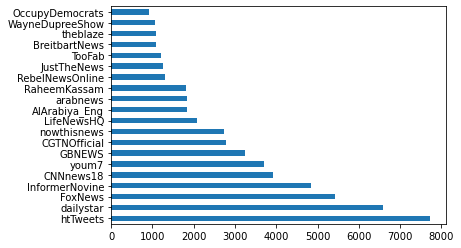

In [60]:
#nb de tweets par utilisateurs (les 20 les plus prolifiques)
tweets.user_screen_name.value_counts()[:20].plot(kind='barh')

In [61]:
#tweets.to_csv("Tache3_tweets.csv")

# Tache 4a - Identifier les liens de citations entre les différents comptes/domaines déjà identifiés en tache 1 et 2.

In [ ]:
#links : bit.ly redirection etc non pris en compte

In [115]:
#pour obtenir les tweets contenant des citations d'un utilisateur vers un autre
#on pourrait aussi faire une fonction qui ne prend pas en compte le 'sens'
def getrelations_fromtweets(tweets_file,socials_file,user_name_from,user_name_to):
    data=pd.read_csv(tweets_file)
    socials=pd.read_csv(socials_file)
    socials=socials[~socials.twitter.isna()]
    #association username twitter, domain
    username2domain=dict(zip(socials.twitter.str.lower(), socials.domain))
    linked_data=[]
    #on garde que les tweets provenant de l'utilisateur source (user_name_from)
    data_considered=data[data.user_screen_name==user_name_from]
    for elt in data_considered.domains :
        flag=False
        #on retransforme string en list
        for x in literal_eval(elt):
            #short url domain in string domain --> est ce que c'est bien le domain en question qui est référencé
            if x in username2domain[user_name_to.lower()] :
                flag=True
                break
        linked_data.append(flag)
    data_considered["linked_data"]=linked_data
    #on garde les tweets partant de user_from qui contienne user_to dans les retweets, quote ou lien/domaines 
    #soit la définition de la citation
    return data_considered[(data_considered.retweeted_user==user_name_to) | (data_considered.quoted_user==user_name_to) | (data_considered.linked_data==True)]

In [116]:
#getrelations_fromtweets à utiliser pour une relation/sens particulier mais pas à itérer
#exemple : quand WayneDupreeShow cite TPInsidr
tweets_file="Tache3_tweets.csv"
socials_file="Tache2_socials.csv"
getrelations_fromtweets(tweets_file,socials_file,"WayneDupreeShow","TPInsidr")

/tmp/ipykernel_67335/3938279303.py:4: DtypeWarning: Columns (53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(tweets_file)
/tmp/ipykernel_67335/3938279303.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_considered["linked_data"]=linked_data


Unnamed: 0                   id           local_time  timestamp_utc  \
70820       70820  1596222229448036353  2022-11-25T19:20:10     1669404010   
70822       70822  1596208391856091136  2022-11-25T18:25:11     1669400711   
70824       70824  1596194601827987457  2022-11-25T17:30:23     1669397423   
70849       70849  1595530206181089280  2022-11-23T21:30:19     1669239019   
70850       70850  1595515111829286913  2022-11-23T20:30:20     1669235420   
...           ...                  ...                  ...            ...   
71827       71827  1587528693555122178  2022-11-01T19:35:10     1667331310   
71828       71828  1587521146282541092  2022-11-01T19:05:10     1667329510   
71839       71839  1587493474802204680  2022-11-01T17:15:13     1667322913   
71844       71844  1587467048656986113  2022-11-01T15:30:12     1667316612   
71846       71846  1587441872565313538  2022-11-01T13:50:10     1667310610   

                                                    text  \
70820  Did your favorite make the cut, ladies? \nhttp...   
70822  Every American needs to see this. \nhttps://th...   
70824  Did your favorite make the list? \nhttps://the...   
70849  It's that time of year again.\nhttps://thepoli...   
70850  We all have more to be thankful for than you m...   
...                                                  ...   
71827  This is what they really think of you.\nhttps:...   
71828  Leftists who claim they're worried about "demo...   
71839  Democrats and the media say criticizing Democr...   
71844  They made parents and grandparents die alone, ...   
71846  No wonder the media ran wild with "MAGA extrem...   

                                                     url  quoted_id  \
70820  https://twitter.com/WayneDupreeShow/status/159...        NaN   
70822  https://twitter.com/WayneDupreeShow/status/159...        NaN   
70824  https://twitter.com/WayneDupreeShow/status/159...        NaN   
70849  https://twitter.com/WayneDupreeShow/status/159...        NaN   
70850  https://twitter.com/WayneDupreeShow/status/159...        NaN   
...                                                  ...        ...   
71827  https://twitter.com/WayneDupreeShow/status/158...        NaN   
71828  https://twitter.com/WayneDupreeShow/status/158...        NaN   
71839  https://twitter.com/WayneDupreeShow/status/158...        NaN   
71844  https://twitter.com/WayneDupreeShow/status/158...        NaN   
71846  https://twitter.com/WayneDupreeShow/status/158...        NaN   

      quoted_user  quoted_user_id  quoted_timestamp_utc  ...  \
70820         NaN             NaN                   NaN  ...   
70822         NaN             NaN                   NaN  ...   
70824         NaN             NaN                   NaN  ...   
70849         NaN             NaN                   NaN  ...   
70850         NaN             NaN                   NaN  ...   
...           ...             ...                   ...  ...   
71827         NaN             NaN                   NaN  ...   
71828         NaN             NaN                   NaN  ...   
71839         NaN             NaN                   NaN  ...   
71844         NaN             NaN                   NaN  ...   
71846         NaN             NaN                   NaN  ...   

                                              user_image  \
70820  https://pbs.twimg.com/profile_images/159310861...   
70822  https://pbs.twimg.com/profile_images/159310861...   
70824  https://pbs.twimg.com/profile_images/159310861...   
70849  https://pbs.twimg.com/profile_images/159310861...   
70850  https://pbs.twimg.com/profile_images/159310861...   
...                                                  ...   
71827  https://pbs.twimg.com/profile_images/159310861...   
71828  https://pbs.twimg.com/profile_images/159310861...   
71839  https://pbs.twimg.com/profile_images/159310861...   
71844  https://pbs.twimg.com/profile_images/159310861...   
71846  https://pbs.twimg.com/profile_images/159310861...   

      

In [124]:
#récupérerer tous les tweets de citations entre les éléments d'une liste de domaines
def getrelations_fromtweets_all(tweets_file,socials_file):
    data=pd.read_csv(tweets_file)
    socials=pd.read_csv(socials_file)
    socials=socials[~socials.twitter.isna()]
    #association username twitter, domain
    username2domain=dict(zip(socials.twitter.str.lower(), socials.domain))
    linked_data=[]
    #on retire les 'fausses' citations ou du moins les citations de soi même 
    #on veut néanmoins que le quoted user ou retweeted user soit dans les domaines considérés 
    #ou qu'il y ait une url dans le tweet (domains)
    data_considered=data[(data.retweeted_user!=data.user_screen_name) & (data.quoted_user!=data.user_screen_name) & ((data.quoted_user.isin(list(set(data.user_screen_name)))) | (data.retweeted_user.isin(list(set(data.user_screen_name)))) | (data.domains!="[]"))]
    for domain,user_screen_name in zip(data_considered.domains,data_considered.user_screen_name) :
        flag=False
        #on retransforme string en list
        for a in literal_eval(domain):
            #short url domain in domains list
            #on ne veut pas de lien vers son propre domain
            if a in [re.sub("http(s)?://(www.)?","",x).strip("/") for x in socials.domain] and a!=re.sub("http(s)?://(www.)?","",username2domain[user_screen_name.lower()]).strip("/") :
                flag=True
                break
        linked_data.append(flag)
    data_considered["linked_data"]=linked_data
    return data_considered[data_considered.linked_data]

In [125]:
tweets_file="Tache3_tweets.csv"
socials_file="Tache2_socials.csv"
relations=getrelations_fromtweets_all(tweets_file,socials_file)

/tmp/ipykernel_67335/1283373686.py:2: DtypeWarning: Columns (53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(tweets_file)
/tmp/ipykernel_67335/1283373686.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_considered["linked_data"]=linked_data


In [126]:
relations

Unnamed: 0                   id           local_time  timestamp_utc  \
5990         5990  1595098230605373443  2022-11-22T16:53:48     1669136028   
6039         6039  1587940428741242881  2022-11-02T22:51:15     1667429475   
7140         7140  1588545611535896582  2022-11-04T14:56:02     1667573762   
8188         8188  1594386815221256192  2022-11-20T17:46:53     1668966413   
8205         8205  1593702266673905665  2022-11-18T20:26:44     1668803204   
...           ...                  ...                  ...            ...   
73479       73479  1587263404938448896  2022-11-01T02:01:00     1667268060   
75067       75067  1595087520907280384  2022-11-22T16:11:14     1669133474   
75218       75218  1595165598811848704  2022-11-22T21:21:30     1669152090   
75506       75506  1596292674595786754  2022-11-26T00:00:05     1669420805   
75521       75521  1592990147666026496  2022-11-16T21:17:02     1668633422   

                                                    text  \
5990   Sweden runs out of space for coronavirus vacci...   
6039   UncoverDC explains v-safe bombshell.\n \n"...D...   
7140   Looks like they fired a "Whistleblower" for ex...   
8188   Yes agree @RonDeSantisFL was received here lik...   
8205   Here’s Everything The New GOP House Should Do ...   
...                                                  ...   
73479  APPLY TODAY: Last chance to apply to CHD’s 202...   
75067  'Conservative' @nancymace says "I love marriag...   
75218  Start the clock, in less than 72 hrs we’re goi...   
75506  A good podcast if anyone out there is looking ...   
75521  A new @CollectiveEvol podcast has just been re...   

                                                     url     quoted_id  \
5990   https://twitter.com/HighWireTalk/status/159509...           NaN   
6039   https://twitter.com/HighWireTalk/status/158794...           NaN   
7140   https://twitter.com/DiamondandSilk/status/1588...  1.588508e+18   
8188   https://twitter.com/JewishVoice/status/1594386...  1.594312e+18   
8205   https://twitter.com/JewishVoice/status/1593702...           NaN   
...                                                  ...           ...   
73479  https://twitter.com/ChildrensHD/status/1587263...           NaN   
75067  https://twitter.com/JhWesten/status/1595087520...           NaN   
75218  https://twitter.com/SaltyCracker9/status/15951...  1.595163e+18   
75506  https://twitter.com/ThePulse_one/status/159629...           NaN   
75521  https://twitter.com/ThePulse_one/status/159299...           NaN   

           quoted_user  quoted_user_id  quoted_timestamp_utc  ...  \
5990               NaN             NaN                   NaN  ...   
6039               NaN             NaN                   NaN  ...   
7140   jsolomonReports     523248016.0          1.667565e+09  ...   
8188     marklevinshow      38495835.0          1.668949e+09  ...   
8205               NaN             NaN                   NaN  ...   
...                ...             ...                   ...  ...   
73479              NaN             NaN                   NaN  ...   
75067              NaN             NaN                   NaN  ...   
75218      Breaking911     375721095.0          1.669151e+09  ...   
75506              NaN             NaN                   NaN  ...   
75521              NaN             NaN                   NaN  ...   

                                              user_image  \
5990   https://pbs.twimg.com/profile_images/142266686...   
6039   https://pbs.twimg.com/profile_images/142266686...   
7140   https://pbs.twimg.com/profile_images/125786641...   
8188   https://pbs.twimg.com/profile_images/149075156...   
8205   https://pbs.twimg.com/profile_images/149075156...   
...                                                  ...   
73479  https://pbs.twimg.com/profile_images/132626282...   
75067  https://pbs.twimg.com/profile_images/155485637...   
75218  https://pbs.twimg.com/profile_images/142123851...   
75506  https://pbs.twimg.com/pr

In [128]:
#relations.to_csv("Tache4a_relations.csv")

In [107]:
#on ne récupère pas les tweets de relations mais on les compte
def getrelations_fromtweets_nb(tweets_file,socials_file):
    data=pd.read_csv(tweets_file)
    socials=pd.read_csv(socials_file)
    socials=socials[~socials.twitter.isna()]
    username2domain=dict(zip(socials.twitter.str.lower(), socials.domain))
    interactionsdict_list=[]
    usernames=list(set(data.user_screen_name))
    for i in usernames :
        for j in usernames :
            interactionsdict=defaultdict(int)
            interactionsdict["from"]=i
            interactionsdict["to"]=j
            interactionsdict["retweets"]=len(data[(data.user_screen_name==i) & (data.retweeted_user==j)])
            interactionsdict["quoted"]=len(data[(data.user_screen_name==i) & (data.quoted_user==j)])
            for elt in data[data.user_screen_name==i].domains :
                #on retransforme string en list
                for x in literal_eval(elt):
                    #short url domain in string domain
                    d=re.sub("http(s)?://(www.)?","",username2domain[j.lower()]).strip("/")
                    if re.match(x,d) :
                        interactionsdict["linked"]+=1
                        break
            interactionsdict_list.append(interactionsdict)
    return pd.DataFrame.from_dict(interactionsdict_list)

In [108]:
relations_nb=getrelations_fromtweets_nb("Tache3_tweets.csv","Tache2_socials.csv")

/tmp/ipykernel_67335/1542490314.py:2: DtypeWarning: Columns (53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(tweets_file)


In [109]:
relations_nb

from               to  retweets  quoted  linked
0         CNNnews18        CNNnews18         0       1   159.0
1         CNNnews18  AmericanThinker         0       0     NaN
2         CNNnews18         joerogan         0       0     NaN
3         CNNnews18          FoxNews         0       0     NaN
4         CNNnews18    realnewspunch         0       0     NaN
...             ...              ...       ...     ...     ...
19039  HighWireTalk         navyhato         0       0     NaN
19040  HighWireTalk   ThoughtCatalog         0       0     NaN
19041  HighWireTalk     CGTNOfficial         0       0     NaN
19042  HighWireTalk   MalcolmOutLoud         0       0     NaN
19043  HighWireTalk     HighWireTalk         0       3    24.0

[19044 rows x 5 columns]

In [110]:
relations_nb=relations_nb.fillna(0)

In [111]:
relations_nb["relations_sum"]=relations_nb["retweets"]+relations_nb["quoted"]+relations_nb["linked"]

In [112]:
#on pourrait retirer les from x to x
relations_nb=relations_nb[relations_nb["from"]!=relations_nb["to"]]

In [113]:
#liens de citations en ordre décroissant
relations_nb.sort_values(by=["relations_sum"],ascending=False)

from               to  retweets  quoted  linked  \
10052  WayneDupreeShow         TPInsidr         0       0   111.0   
1383          CDNPosts          FoxNews         0      19     0.0   
17206    SaltyCracker9      Breaking911         0       7     2.0   
9939   WayneDupreeShow          FoxNews         0       8     0.0   
15668  jordanbpeterson           GBNEWS         0       4     2.0   
...                ...              ...       ...     ...     ...   
6352          GrungeHQ    realnewspunch         0       0     0.0   
6351          GrungeHQ          FoxNews         0       0     0.0   
6350          GrungeHQ         joerogan         0       0     0.0   
6349          GrungeHQ  AmericanThinker         0       0     0.0   
19042     HighWireTalk   MalcolmOutLoud         0       0     0.0   

       relations_sum  
10052          111.0  
1383            19.0  
17206            9.0  
9939             8.0  
15668            6.0  
...              ...  
6352             0.0  
6351             0.0  
6350             0.0  
6349             0.0  
19042            0.0  

[18906 rows x 6 columns]

In [114]:
#relations_nb.to_csv("Tache4a_relations_count.csv")

#  Tache 4b - Identifier des nouveaux candidats : des domaines/comptes souvent cités mais qui n’ont pas été identifiés en tache 1 et 2.

In [118]:
#on récupère les username des quoted id en dehors de notre liste de domaines de la tache 1 /2 
def getcandidates_fromtweets_quoted_nb(tweets_file):
    data=pd.read_csv(tweets_file)
    remove=[x for x in list(set(data.user_screen_name)) if x in data.quoted_user.value_counts().keys()]
    return data.quoted_user.value_counts().drop(labels=remove)

In [ ]:
#si on prend l'exemple des quoted_user
#on pourrait aussi faire sur l'ensemble (quoted + retweeted + linked)

In [120]:
tweets_file="Tache3_tweets.csv"
relations_candidates=getcandidates_fromtweets_quoted_nb(tweets_file)

/tmp/ipykernel_67335/3373941241.py:2: DtypeWarning: Columns (53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(tweets_file)


In [121]:
relations_candidates

cgtnamerica        443
elonmusk            49
Panda_Paws_         30
greg_price11        21
bennyjohnson        18
                  ... 
Logically_JC         1
LandauDave           1
MissAngryFlower      1
RealLyndaCarter      1
JonSchweppe          1
Name: quoted_user, Length: 762, dtype: int64

In [123]:
#relations_candidates.to_csv("Tache4b_other_relations_candidates.csv")

In [2]:
#tweets avec citations en dehors de la liste de domaines considérés
def get_other_relations(tweets_file,socials_file):
    data=pd.read_csv(tweets_file)
    socials=pd.read_csv(socials_file)
    socials=socials[~socials.twitter.isna()]
    username2domain=dict(zip(socials.twitter.str.lower(), socials.domain))
    linked_data=[]
    data_considered=data[(data.retweeted_user!=data.user_screen_name) & (data.quoted_user!=data.user_screen_name) & ((~data.quoted_user.isin(list(set(data.user_screen_name)))) | (~data.retweeted_user.isin(list(set(data.user_screen_name)))) | (data.domains!="[]"))]
    data_considered=data_considered.fillna("")
    for domain,user_url in zip(data_considered.domains,data_considered.user_url) :
        flag=False
        #on retransforme string en list
        for a in literal_eval(domain):
            #short url domain not in domains list
            if a not in [re.sub("http(s)?://(www.)?","",x).strip("/") for x in socials.domain] and a!=re.sub("http(s)?://(www.)?","",user_url).strip("/") :
                flag=True
                break
        linked_data.append(flag)
    data_considered["linked_data"]=linked_data
    return data_considered[data_considered.linked_data]

In [3]:
tweets_file="Tache3_tweets.csv"
socials_file="Tache2_socials.csv"
other_relations_excludedlist=get_other_relations(tweets_file,socials_file)

/tmp/ipykernel_102816/3801236242.py:3: DtypeWarning: Columns (53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(tweets_file)


In [4]:
other_relations_excludedlist

Unnamed: 0                   id           local_time  timestamp_utc  \
0               0  1596580293343055873  2022-11-26T19:02:59     1669489379   
1               1  1596569232887930880  2022-11-26T18:19:02     1669486742   
4               4  1596558361558151170  2022-11-26T17:35:50     1669484150   
6               6  1596553642043400193  2022-11-26T17:17:05     1669483025   
10             10  1596548809110102016  2022-11-26T16:57:53     1669481873   
...           ...                  ...                  ...            ...   
75524       75524  1592291428960538625  2022-11-14T23:00:34     1668466834   
75533       75533  1588578182340685824  2022-11-04T17:05:27     1667581527   
75539       75539  1587829106758000640  2022-11-02T15:28:54     1667402934   
76260       76260  1594687795318034432  2022-11-21T13:42:52     1669038172   
77126       77126  1592264860896616448  2022-11-14T21:15:00     1668460500   

                                                    text  \
0      #FIFA : IT'S NOW OR NEVER FOR #MESSI! Will #Ar...   
1      COMING UP: Messi's #Argentina takes on #Mexico...   
4      France scores, Denmark equalises! Who will eme...   
6      Football #WorldCup2022 : The second half of #F...   
10     #LIVE | #GujaratElections2022 : Mapping the po...   
...                                                  ...   
75524  This event was just one more step towards a la...   
75533  Tamara Lich "I was becoming increasingly alarm...   
75539  Help us combat censorship and stay afloat. Bec...   
76260  يلا شات أقوى تطبيق مراسلة عربى بامتياز.. يدعم ...   
77126  خدمة وشوشة: "خطيبى كذب على أهلي.. مش عارفة أثق...   

                                                     url quoted_id  \
0      https://twitter.com/CNNnews18/status/159658029...             
1      https://twitter.com/CNNnews18/status/159656923...             
4      https://twitter.com/CNNnews18/status/159655836...             
6      https://twitter.com/CNNnews18/status/159655364...             
10     https://twitter.com/CNNnews18/status/159654880...             
...                                                  ...       ...   
75524  https://twitter.com/ThePulse_one/status/159229...             
75533  https://twitter.com/ThePulse_one/status/158857...             
75539  https://twitter.com/ThePulse_one/status/158782...             
76260  https://twitter.com/youm7/status/1594687795318...             
77126  https://twitter.com/youm7/status/1592264860896...             

      quoted_user quoted_user_id quoted_timestamp_utc  ...  \
0                                                      ...   
1                                                      ...   
4                                                      ...   
6                                                      ...   
10                                                     ...   
...           ...            ...                  ...  ...   
75524                                                  ...   
75533                                                  ...   
75539                                                  ...   
76260                                                  ...   
77126                                                  ...   

                                              user_image  \
0      https://pbs.twimg.com/profile_images/155978869...   
1      https://pbs.twimg.com/profile_images/155978869...   
4      https://pbs.twimg.com/profile_images/155978869...   
6      https://pbs.twimg.com/profile_images/155978869...   
10     https://pbs.twimg.com/profile_images/155978869...   
...                                                  ...   
75524  https://pbs.twimg.com/profile_images/139866446...   
75533  https://pbs.twimg.com/profile_images/139866446...   
75539  https://pbs.twimg.com/profile_images/139866446...   
76260  https://pbs.twimg.com/profile_images/157878124...   
77126  https://pbs.twimg.com/profile_images/157878124...   

                    user_url user_timestam

In [5]:
#other_relations_excludedlist.to_csv("Tache4b_tweets_citations_horsdomains.csv")

In [6]:
other_relations_excluded_df=pd.read_csv("Tache4b_tweets_citations_horsdomains.csv")

In [8]:
#il faudra nettoyer en enlevant lien de réseaux sociaux + bit.ly etc
from ast import literal_eval
from collections import Counter
from pandas.core.common import flatten
list_domains_corpus=[literal_eval(x) for x in list(other_relations_excluded_df.domains)]
#on compte les apparitions dans les différents liens des tweets gardés avec citations hors de notre liste de domaines
candidates_url=pd.DataFrame(sorted(Counter(list(flatten(list_domains_corpus))).items(),key= lambda x:x[1],reverse=True),columns=['domain',"count"])

In [11]:
candidates_url[:30]

domain  count
0                  fxn.ws   5423
1                 trib.al   4168
2                  bit.ly   3161
3               arab.news   1741
4             twitter.com   1228
5                 dlvr.it    995
6              rebelne.ws    793
7                  zpr.io    787
8             tinyurl.com    675
9           news.cgtn.com    657
10                buff.ly    595
11            go.nowth.is    435
12  truckercommission.com    320
13               youtu.be    295
14                 ift.tt    278
15                  wp.me    230
16             rumble.com    196
17            youtube.com    195
18              gbnews.uk    171
19    bangla.bdnews24.com    156
20    washingtonpress.com    144
21              jwatch.us    115
22                  ow.ly     91
23           facebook.com     61
24          instagram.com     58
25                bddy.me     51
26                hubs.la     51
27                 okt.to     50
28                geni.us     50
29             eepurl.com     48

In [14]:
#candidates_url[candidates_url["count"]>10].to_csv("Tache4b_candidates based onlinks.csv")

# Graphes / Autres

In [ ]:
#est ce que les autres gens/liens qu'ils identifient souvent sont dans les listes de mediabiasfactcheck 
#--> si oui leur credibility score

In [ ]:
#Sankey graph interactif avec plotly ? pour représenter la part de liens/citations entre les différents utilisateurs
#sentiment analysis of quoted tweets

In [ ]:
#Undirected Graph (si on ne s'intéresse pas au sens des citations) ou directed sinon

"""import networkx as nx
graph = nx.Graph()"""
#node = users 
#edge = nb de citations/interactions dans un sens user1 cite user2 dans l'autre user2 cite user1
#somme des citations ne pas différencier quoted retweet linked ?